In [1]:
from datetime import date

import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

from scipy.stats import norm

In [2]:
Mat = "2023-09-15"  # Fill in the maturity you want to consider here!

ticker = yf.Ticker("IBM")
options = ticker.options

chain = ticker.option_chain(Mat)
data = ticker.history(period="5y")
price = data.iloc[-1]['Close']

callData = chain.calls
putData = chain.puts

callData.head(5)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,IBM230915C00065000,2023-05-08 19:41:21+00:00,65.0,58.50,69.35,70.40,0.0,0.0,2.0,0,0.757327,True,REGULAR,USD
1,IBM230915C00080000,2023-05-08 19:47:39+00:00,80.0,43.50,54.75,55.55,0.0,0.0,3.0,0,0.594975,True,REGULAR,USD
2,IBM230915C00085000,2023-05-08 17:21:56+00:00,85.0,37.75,49.40,50.65,0.0,0.0,15.0,0,0.552495,True,REGULAR,USD
3,IBM230915C00090000,2023-03-13 16:45:01+00:00,90.0,36.90,38.65,39.45,0.0,0.0,3.0,11,0.000010,True,REGULAR,USD
4,IBM230915C00095000,2023-05-04 19:15:56+00:00,95.0,27.35,36.90,39.35,0.0,0.0,6.0,19,0.000010,True,REGULAR,USD


### Volatility Smirk : When volatility smile curve exihibits skewness mostly due to increased demand of put options as a hedge for crashes

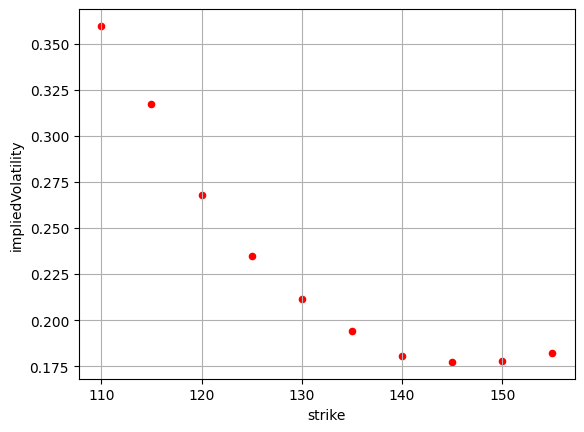

In [26]:
df_call = callData
df_call["impliedVolatility"] = df_call["impliedVolatility"].astype(float)
df_call = df_call[df_call["impliedVolatility"] > 0]
df_call["strike"] = df_call["strike"].astype(float)
df_call = df_call[
    df_call["strike"] > price * 0.8
]  # We will only consider those options within a certain range of the current price
df_call = df_call[
    df_call["strike"] < price * 1.2
]  # One reason for this is that it is precisely those options that are most often traded.


df_call.plot(kind="scatter", x="strike", y="impliedVolatility", color="red")
plt.grid()
plt.show()

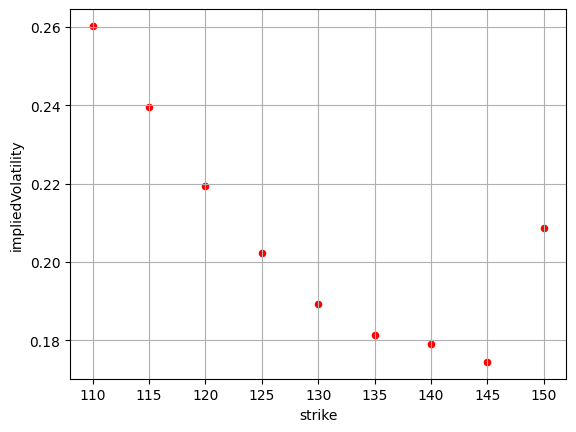

In [27]:
df_put = putData
df_put["impliedVolatility"] = df_put["impliedVolatility"].astype(float)
df_put = df_put[df_put["impliedVolatility"] > 0]
df_put["strike"] = df_put["strike"].astype(float)
df_put = df_put[
    df_put["strike"] > price * 0.8
]  # We will only consider those options within a certain range of the current price
df_put = df_put[
    df_put["strike"] < price * 1.2
]  # One reason for this is that it is precisely those options that are most often traded.


df_put.plot(kind="scatter", x="strike", y="impliedVolatility", color="red")
plt.grid()
plt.show()

## Newton Raphson Method

In [3]:
N_prime = norm.pdf
N = norm.cdf

In [4]:
def black_scholes_call(S, K, T, r, sigma):
    """
    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    """

    # Black-Scholes Formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) - N(d2) * K * np.exp(-r * T)
    return call

In [5]:
def vega(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    """

    # Calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / sigma * np.sqrt(T)
    vega = S * np.sqrt(T) * N_prime(d1)
    return vega

In [7]:
def implied_volatility_call(C, S, K, T, r, tol=0.0001, max_iterations=100):
    """

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: risk free rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    """

    # assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.3

    for i in range(max_iterations):
        # calculate difference between black-scholes price and market price with
        # iteratively updated volatility estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        # break if difference is less than specified tolerance level
        if abs(diff) < tol:
            print(f"found on {i}th iteration")
            print(f"difference is equal to {diff}")
            break

        # use Newton-Rapshon to update the estimate
        sigma = sigma - diff / vega(S, K, T, r, sigma)

    return sigma

In [11]:
observed_price = 31
S = 202
K = 215
T = 1
r = 0.05

imp_vol = implied_volatility_call(observed_price, S, K, T, r)
print("Implied volatility using Newton Rapshon is: ", imp_vol)

found on 2th iteration
difference is equal to -6.099237310763783e-07
Implied volatility using Newton Rapshon is:  0.4002738252223597
